In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import re
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from datetime import datetime
from tsfresh import extract_features as ts_extract_features
from tsfresh.feature_selection.selection import select_features

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.base import clone
from copy import deepcopy

color = sns.color_palette()

# Set global variables

In [2]:
_PATH_TO_FEATURES = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\features.csv"
_PATH_TO_GT = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\patient_data.csv"
_PATH_TO_ACTIVITY_DATA = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\activity_data"

_VISUALIZE_PATIENT = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\activity_data\\patient_activity_57.csv"

In [3]:
_RANDOM_SEED = 0
_NUMBER_OF_FOLDS = 10
_NUMBER_OF_FEATURES = 20
_TEST_RATIO = .30

In [4]:
_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 0, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 1000, "criterion": "entropy",
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": _RANDOM_SEED,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    'objective':'binary:logistic', "learning_rate": .01
}

_PARAMS_LIGHTGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    "objective": "binary", "learning_rate": .01
}

# Define functions

In [5]:
def k_fold_model_evaluation( model_func, model_parameters, fit_parameters={}, n_splits=_NUMBER_OF_FOLDS, shuffle=True, random_state=_RANDOM_SEED ):

    y_preds, y_trues = [], []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state)

    models = [ ]
    k_fold_results = [ ]

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        model = model_func(**model_parameters)
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index], X_TRAIN.iloc[fold_index]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = model.fit( x_fold_train, y_fold_train, **fit_parameters )
        models.append( deepcopy(model) )

        y_pred = model.predict_proba( x_fold_test )[:, 1]
        
        k_fold_results.append((list(y_pred), list(y_fold_test)))
    
    return models, np.array(k_fold_results)

In [6]:
def cv_confusion_matrix(k_fold_results, average=True):
    cm = np.zeros((2,2))
    for fold_index, (y_pred, y_true) in enumerate(k_fold_results):
        y_pred = np.round(y_pred)
        cm += metrics.confusion_matrix(y_true, y_pred)
    if average:
        return cm / len(k_fold_results)
    return cm

In [7]:
def calculate_cv_results(cv_results):
    cv_metrics = defaultdict(list)
    for fold_index, fold_results in enumerate(cv_results):
        y_preds, y_trues = fold_results
        y_preds = np.round(np.array(y_preds, dtype=np.float32))
        cv_metrics["Fold"].append("Fold %i" % fold_index)
        cv_metrics["Accuracy"].append(metrics.accuracy_score(y_trues, y_preds))
        cv_metrics["Precision"].append(metrics.precision_score(y_trues, y_preds, average="binary"))
        cv_metrics["Recall"].append(metrics.recall_score(y_trues, y_preds, average="binary"))
        cv_metrics["F1-Score"].append(metrics.f1_score(y_trues, y_preds, average="binary"))
        cv_metrics["MCC"].append(metrics.matthews_corrcoef(y_trues, y_preds))
    return pd.DataFrame(data=dict(cv_metrics))

In [8]:
def plot_au_curves(k_fold_results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    precision = dict()
    recall = dict()
    average_precision = dict()

    all_preds = []
    all_trues = []

    for i, (y_pred, y_true) in enumerate(k_fold_results):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, y_pred)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_true, y_pred)
        average_precision[i] = metrics.average_precision_score(y_true, y_pred)
        all_preds.extend(y_pred)
        all_trues.extend(y_true)

    fpr["mean"], tpr["mean"], _ = metrics.roc_curve(all_trues, all_preds)
    roc_auc['mean'] = metrics.auc(fpr['mean'], tpr['mean'])
    precision["mean"], recall["mean"], _ = metrics.precision_recall_curve(all_trues, all_preds)
    average_precision['mean'] = metrics.average_precision_score(all_trues, all_preds)


    fig = plt.figure(figsize=(18,6))

    # auroc
    ax1 = fig.add_subplot(121)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
            label='Chance', alpha=.8)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # for i in range(len(k_fold_results)):
    #     ax1.plot(fpr[i], tpr[i], color=colors[i],
    #         label=r'ROC Fold %i (AUC = %0.2f)' % (i+1,roc_auc[i]),
    #         lw=3, alpha=.5)

    ax1.plot(fpr['mean'], tpr['mean'], color='b',
            label=r'Mean ROC (AUC = %0.2f)' % (roc_auc['mean']),
            lw=4, alpha=.8)    

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Receiver Operating Characteristic Curve", size=20)
    plt.xlabel('False Positive Rate',size=20); plt.xticks(size=15)
    plt.ylabel('True Positive Rate',size=20); plt.yticks(size=15)
    ax1.legend(loc="lower right",prop={"size":15})

    # auprc
    ax2 = fig.add_subplot(122)

    # for i in range(len(k_fold_results)):
    #     ax2.step(recall[i], precision[i], where='post', color=colors[i],
    #              label=r'AP Fold %i (AP = %0.2f)' % (i+1,average_precision[i]),
    #              lw=3, alpha=.5)

    ax2.step(recall['mean'], precision['mean'], where='post', color='b',
            label=r'Mean AP (AP = %0.2f)' % (average_precision['mean']),
            lw=4, alpha=.8)    

    ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Precision Recall Curve", size=20)
    plt.xlabel('Recall',size=20); plt.xticks(size=15)
    plt.ylabel('Precision',size=20); plt.yticks(size=15)
    ax2.legend(loc="lower left",prop={"size":15})
    
    
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax1_figure.png', bbox_inches=bbox)
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax2_figure_expanded.png', bbox_inches=bbox)

    plt.show()

# Visualize the dataset

In [9]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")
dataY.columns

Index(['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME',
       'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY',
       'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS',
       'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab',
       'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep',
       'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$'],
      dtype='object')

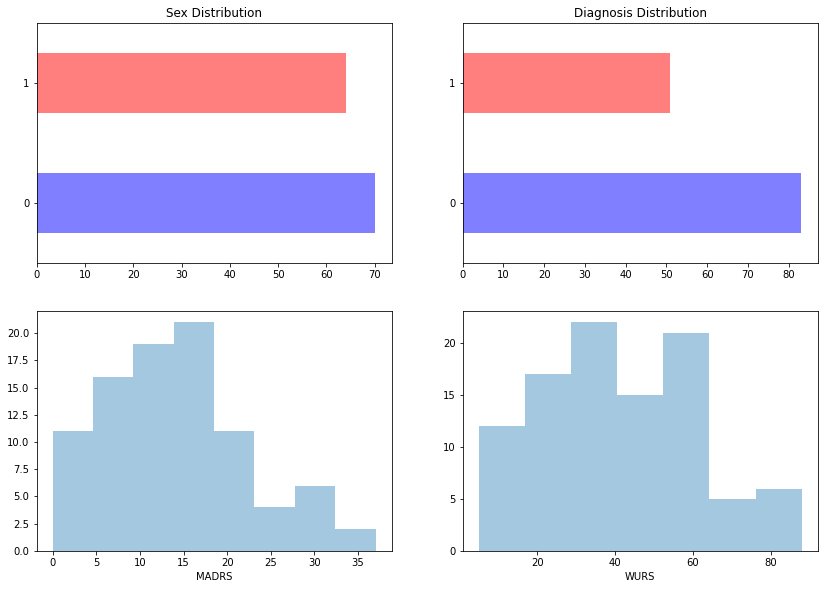

In [10]:
fig = plt.figure(figsize=(14,15))

ax2 = fig.add_subplot(321)
ax2 = dataY['SEX'].value_counts().plot(kind='barh', color=['blue','red'], alpha=.5,
                                                  title='Sex Distribution')
ax3 = fig.add_subplot(322)
ax3 = dataY['ADHD'].value_counts().plot(kind='barh', color=['blue','red', 'green'], alpha=.5,
                                                  title='Diagnosis Distribution')
ax5 = fig.add_subplot(323)
ax5 = sns.distplot(dataY['MADRS'], kde=False)

ax5 = fig.add_subplot(324)
ax5 = sns.distplot(dataY['WURS'], kde=False)

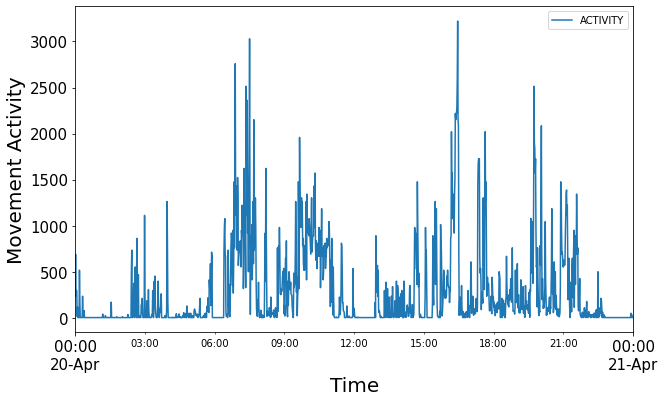

In [11]:
patient_activity_data = pd.read_csv(_VISUALIZE_PATIENT, sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")
patient_activity_data = patient_activity_data.set_index(['TIMESTAMP'])

patient_activity_data.loc['2010-04-20 00:00:00':'2010-04-21 00:00:00'].plot(kind='line', figsize=(10,6))

plt.xlabel('Time',size=20); plt.xticks(size=15)
plt.ylabel('Movement Activity',size=20); plt.yticks(size=15)

plt.show()

# Find most important features

In [12]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")

dataX = dataX.fillna(0)

# Remove JSON symbols from headers
dataX = dataX.rename(columns = lambda x:re.sub('"', '', x))
dataX = dataX.rename(columns = lambda x:re.sub(',', '', x))
dataY = dataY.rename(columns = lambda x:re.sub('"', '', x))
dataY = dataY.rename(columns = lambda x:re.sub(',', '', x))

# Match X and Y data
dataY = dataY[dataY["ID"].isin(dataX["ID"])]
dataX = dataX[dataX["ID"].isin(dataY["ID"])]

dataY = dataY.set_index("ID")
dataX = dataX.set_index("ID")

dataY = dataY["ADHD"].copy()

# Find relevant features using tsfresh
dataX = select_features(dataX, dataY)

scaler = StandardScaler(copy=True)
dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=_TEST_RATIO,
    random_state=_RANDOM_SEED,
    stratify=dataY)

# Logistic Regression

In [13]:
lr_models, k_fold_results = k_fold_model_evaluation( LogisticRegression, _PARAMS_LORGREG )

## Validation Evaluation

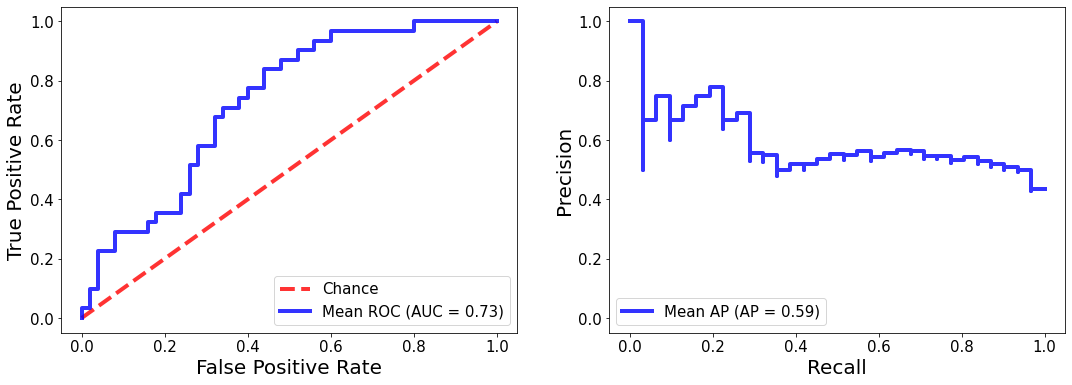

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,0.666667,0.500000,0.571429,0.316228
1,Fold 1,0.625000,0.500000,0.666667,0.571429,0.258199
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.750000,0.600000,1.000000,0.750000,0.600000
5,Fold 5,0.625000,0.500000,1.000000,0.666667,0.447214
6,Fold 6,0.500000,0.400000,0.666667,0.500000,0.066667
7,Fold 7,0.500000,0.333333,0.333333,0.333333,-0.066667
8,Fold 8,0.750000,0.666667,0.666667,0.666667,0.466667
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [14]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

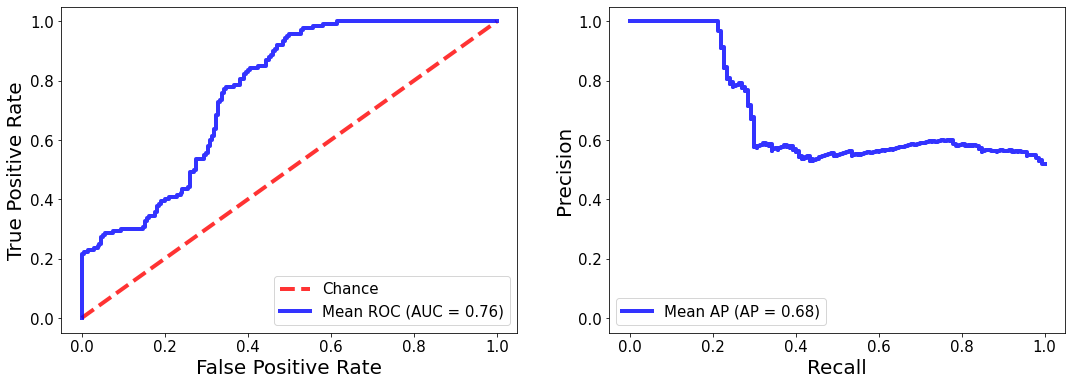

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.628571,0.545455,0.428571,0.480000,0.201008
1,Fold 1,0.714286,0.611111,0.785714,0.687500,0.443422
2,Fold 2,0.714286,0.625000,0.714286,0.666667,0.421464
3,Fold 3,0.714286,0.625000,0.714286,0.666667,0.421464
4,Fold 4,0.742857,0.631579,0.857143,0.727273,0.515122
5,Fold 5,0.685714,0.578947,0.785714,0.666667,0.398049
6,Fold 6,0.628571,0.526316,0.714286,0.606061,0.280976
7,Fold 7,0.685714,0.588235,0.714286,0.645161,0.373408
8,Fold 8,0.685714,0.588235,0.714286,0.645161,0.373408
9,Fold 9,0.714286,0.611111,0.785714,0.687500,0.443422


In [15]:
test_cv_results = []
for model in lr_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

# Random Forest

In [16]:
rf_models, k_fold_results = k_fold_model_evaluation( RandomForestClassifier, _PARAMS_RFC )

## Validation Evaluation

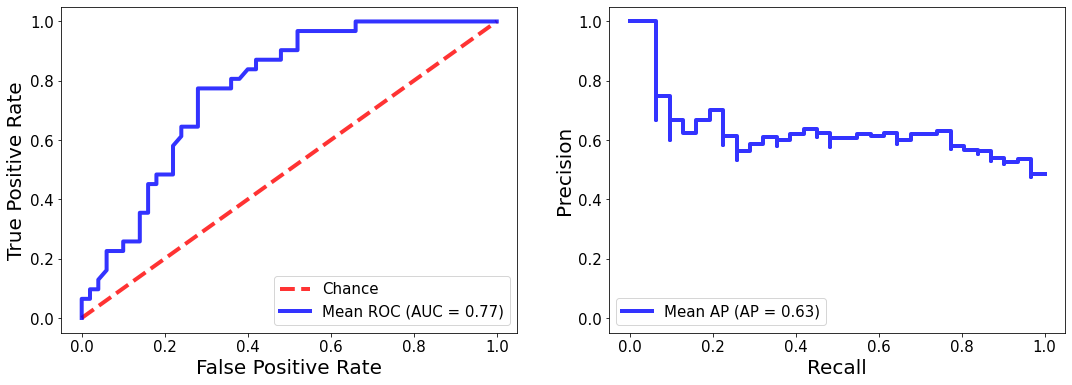

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.750000,0.666667,0.666667,0.666667,0.466667
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.625000,0.500000,0.666667,0.571429,0.258199
4,Fold 4,0.750000,0.600000,1.000000,0.750000,0.600000
5,Fold 5,0.750000,0.600000,1.000000,0.750000,0.600000
6,Fold 6,0.625000,0.500000,0.666667,0.571429,0.258199
7,Fold 7,0.625000,0.500000,0.666667,0.571429,0.258199
8,Fold 8,0.750000,0.666667,0.666667,0.666667,0.466667
9,Fold 9,0.750000,1.000000,0.333333,0.500000,0.487950


In [17]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

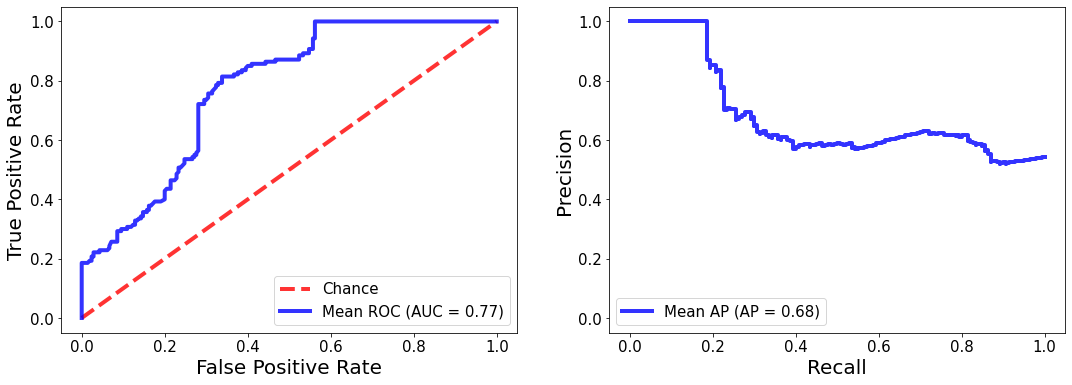

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.657143,0.625000,0.357143,0.454545,0.250000
1,Fold 1,0.657143,0.571429,0.571429,0.571429,0.285714
2,Fold 2,0.628571,0.538462,0.500000,0.518519,0.217262
3,Fold 3,0.657143,0.583333,0.500000,0.538462,0.270310
4,Fold 4,0.685714,0.615385,0.571429,0.592593,0.337963
5,Fold 5,0.657143,0.583333,0.500000,0.538462,0.270310
6,Fold 6,0.685714,0.600000,0.642857,0.620690,0.353553
7,Fold 7,0.657143,0.583333,0.500000,0.538462,0.270310
8,Fold 8,0.657143,0.571429,0.571429,0.571429,0.285714
9,Fold 9,0.714286,0.642857,0.642857,0.642857,0.404762


In [18]:
test_cv_results = []
for model in rf_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

# XGBoost

## Model Training

In [19]:
xgb_models, k_fold_results = k_fold_model_evaluation( xgb.XGBClassifier, _PARAMS_XGB )

C:\Users\Steven\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Steven\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Validation Evaluation

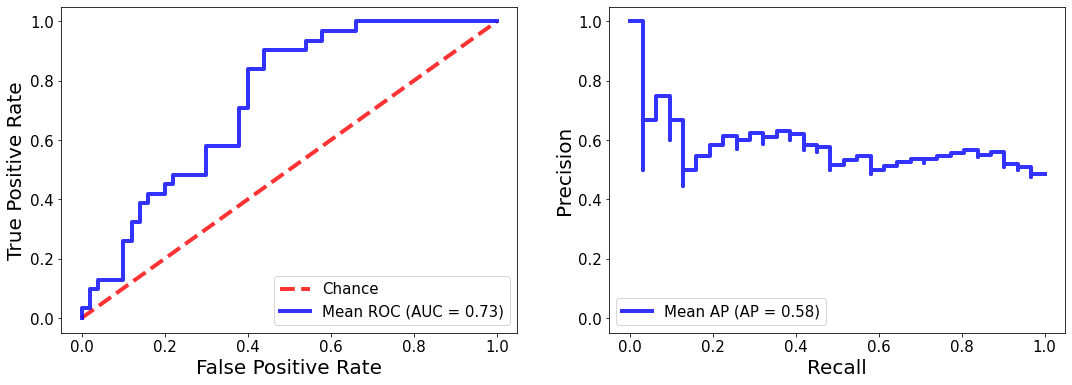

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.375000,0.000000,0.000000,0.000000,-0.447214
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.375000,0.250000,0.333333,0.285714,-0.258199
5,Fold 5,0.875000,0.750000,1.000000,0.857143,0.774597
6,Fold 6,0.500000,0.400000,0.666667,0.500000,0.066667
7,Fold 7,0.625000,0.500000,0.666667,0.571429,0.258199
8,Fold 8,0.625000,0.500000,0.666667,0.571429,0.258199
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [20]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

C:\Users\Steven\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


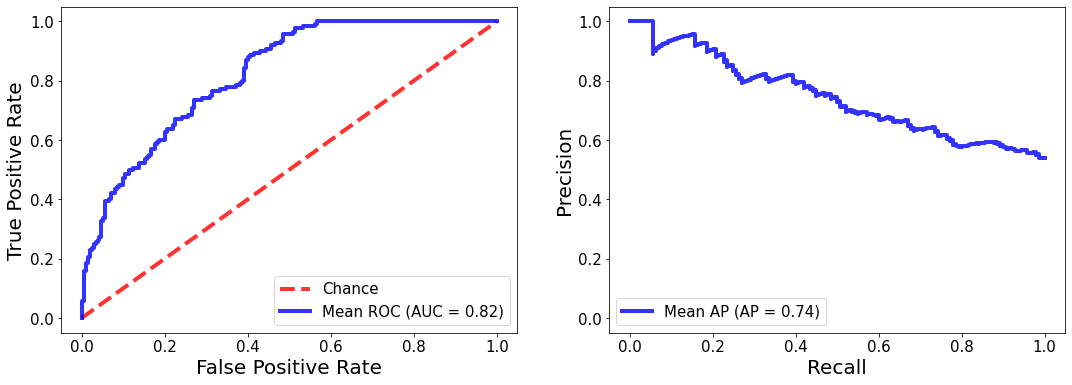

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.742857,0.777778,0.500000,0.608696,0.453696
1,Fold 1,0.714286,0.700000,0.500000,0.583333,0.387298
2,Fold 2,0.657143,0.571429,0.571429,0.571429,0.285714
3,Fold 3,0.742857,0.692308,0.642857,0.666667,0.458664
4,Fold 4,0.800000,0.733333,0.785714,0.758621,0.589256
5,Fold 5,0.742857,0.692308,0.642857,0.666667,0.458664
6,Fold 6,0.685714,0.588235,0.714286,0.645161,0.373408
7,Fold 7,0.685714,0.588235,0.714286,0.645161,0.373408
8,Fold 8,0.742857,0.692308,0.642857,0.666667,0.458664
9,Fold 9,0.771429,0.750000,0.642857,0.692308,0.516047


In [21]:
test_cv_results = []
for model in xgb_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

# LightGBM

In [22]:
gbm_models, k_fold_results = k_fold_model_evaluation( lgb.LGBMClassifier, _PARAMS_LIGHTGB, {"verbose": False} )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Finished loading model, total used 1000 iterations
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Finished loading model, total used 1000 iterations
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Finished loading model, total used 1000 iterations
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Validation Evaluation

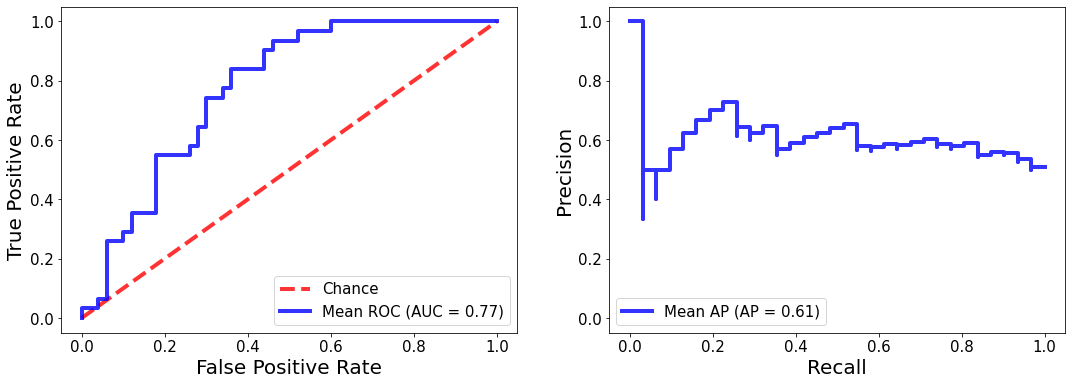

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.625000,0.500000,0.666667,0.571429,0.258199
2,Fold 2,0.875000,1.000000,0.666667,0.800000,0.745356
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.625000,0.500000,1.000000,0.666667,0.447214
5,Fold 5,0.875000,0.750000,1.000000,0.857143,0.774597
6,Fold 6,0.375000,0.250000,0.333333,0.285714,-0.258199
7,Fold 7,0.500000,0.400000,0.666667,0.500000,0.066667
8,Fold 8,0.750000,0.666667,0.666667,0.666667,0.466667
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [23]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

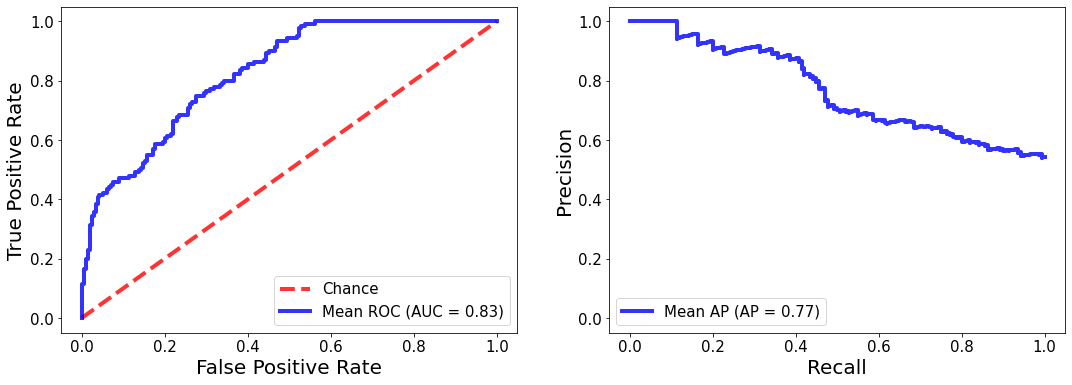

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.714286,0.750000,0.428571,0.545455,0.388889
1,Fold 1,0.685714,0.600000,0.642857,0.620690,0.353553
2,Fold 2,0.685714,0.615385,0.571429,0.592593,0.337963
3,Fold 3,0.714286,0.642857,0.642857,0.642857,0.404762
4,Fold 4,0.742857,0.666667,0.714286,0.689655,0.471405
5,Fold 5,0.742857,0.666667,0.714286,0.689655,0.471405
6,Fold 6,0.685714,0.600000,0.642857,0.620690,0.353553
7,Fold 7,0.800000,0.769231,0.714286,0.740741,0.579365
8,Fold 8,0.714286,0.625000,0.714286,0.666667,0.421464
9,Fold 9,0.742857,0.727273,0.571429,0.640000,0.452267


In [24]:
test_cv_results = []
for model in gbm_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)